문제정의: KNeighborsClassifier 사용하여 타이타닉 생존자(1), 사망(0) 예측하기

기본 라이브러리 불러오기

In [1]:
import pandas as pd
import seaborn as sns

한글 깨짐 방지

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


step01. 데이터 준비 - seaborn에서 제공하는 titanic 데이터 셋 가져오기

In [3]:
# load_dataset 함수를 사용하여 데이터 프레임으로 변환하기
df = sns.load_dataset('titanic')


step02. 데이터 탐색 및 데이터 전처리

In [4]:
df.head()

# sibsp: 동승자 // fare: 티켓 가격 // embarked: 탑승한 항구명 

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [6]:
# deck는 널값이 많으므로 삭제하자
# embarked와 embark_town은 비슷하므로 embark_town은 삭제하자

# --> NaN값이 많은 deck(객실 데크 위치) 열을 삭제, embarked와 내용이 겹치는 embark_town(승선 도시) 열을 삭제

rdf = df.drop(['deck', 'embark_town'], axis=1)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    891 non-null    int64   
 1   pclass      891 non-null    int64   
 2   sex         891 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        891 non-null    float64 
 7   embarked    889 non-null    object  
 8   class       891 non-null    category
 9   who         891 non-null    object  
 10  adult_male  891 non-null    bool    
 11  alive       891 non-null    object  
 12  alone       891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 72.4+ KB


In [7]:
# age 열에 나이 데이터가 없는 모든 행을 삭제하기 --> 177개의 nan 삭제하기

rdf = rdf.dropna(subset=['age'],how='any', axis = 0)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    712 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [8]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값 확인 -> 탑승한 도시의 첫글자

most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
most_freq

'S'

In [9]:
rdf.describe(include='all')

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alive,alone
count,714.000000,714.000000,714,714.000000,714.000000,714.000000,714.000000,712,714,714,714,714,714
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,no,True
freq,NaN,NaN,453,NaN,NaN,NaN,NaN,554,355,413,413,424,404
mean,0.406162,2.236695,NaN,29.699118,0.512605,0.431373,34.694514,NaN,NaN,NaN,NaN,NaN,NaN
std,0.491460,0.838250,NaN,14.526497,0.929783,0.853289,52.918930,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,1.000000,NaN,20.125000,0.000000,0.000000,8.050000,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,2.000000,NaN,28.000000,0.000000,0.000000,15.741700,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,1.000000,33.375000,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기

rdf['embarked'].fillna(most_freq, inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


step03. 분석에 사용할 속성을 선택

In [11]:
# 분석에 활용할 열(속성)을 선택 (생존여부, 객실 등급, 성별, 나이, 타이타닉에 탑승한 형제/자매의 수,
# 타이타닉에 탑승한 부모, 자식의 수, 탑승한 곳(항구), C = Cherbourg, Q = Queenstown, S = Southampton)

rdf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
rdf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [12]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변경하기
# male, female -> [1, 0], [0, 1]
# embarked C, Q, S -> [1, 0, 0], [0, 1, 0], [0, 0, 1]

onehot_sex = pd.get_dummies(rdf['sex'])
onehot_sex

rdf = pd.concat([rdf, onehot_sex], axis=1)

rdf

,survived,pclass,sex,age,sibsp,parch,embarked,female,male
0,0,3,male,22.0,1,0,S,0,1
1,1,1,female,38.0,1,0,C,1,0
2,1,3,female,26.0,0,0,S,1,0
3,1,1,female,35.0,1,0,S,1,0
4,0,3,male,35.0,0,0,S,0,1
...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,Q,1,0
886,0,2,male,27.0,0,0,S,0,1
887,1,1,female,19.0,0,0,S,1,0
889,1,1,male,26.0,0,0,C,0,1


In [13]:
# embarked C, Q, S -> [1, 0, 0], [0, 1, 0], [0, 0, 1]

onehot_embarked = pd.get_dummies(rdf['embarked'], prefix='town')

# onehot_embarked

rdf = pd.concat([rdf, onehot_embarked], axis=1)
rdf.head()

,survived,pclass,sex,age,sibsp,parch,embarked,female,male,town_C,town_Q,town_S
0,0,3,male,22.0,1,0,S,0,1,0,0,1
1,1,1,female,38.0,1,0,C,1,0,1,0,0
2,1,3,female,26.0,0,0,S,1,0,0,0,1
3,1,1,female,35.0,1,0,S,1,0,0,0,1
4,0,3,male,35.0,0,0,S,0,1,0,0,1


In [14]:
# 기존 컬럼 삭제하기
rdf.drop(['sex', 'embarked'], axis=1, inplace=True)

rdf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


In [15]:
rdf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


step04. 데이터 셋 구분 - 훈련용(train data) / 검증용(test data)

In [18]:
# rdf -> X, y (문제집, 정답지) 로 구분

X = rdf[['pclass',	'age',	'sibsp',	'parch',	'female',	'male',	'town_C',	'town_Q',	'town_S']] # 독립변수
y = rdf['survived']



In [20]:
# train 데이터와 test 데이터로 구분 (7:3 비율)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 7)

print(X_train.shape)
print(X_test.shape)

(499, 9)
(215, 9)


step05. KNN 분류 모형 - sklearn 사용

In [24]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성(k=5로 설정하기)
knn = KNeighborsClassifier(n_neighbors= 5)

In [25]:
# train 데이터를 사용하여 모형 학습하기
knn.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [29]:
# test 데이터를 가지고 y_hat을 예측하기(분류)
y_hat = knn.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 0 1 1 0 0 0 0 0]
[0 1 0 1 0 0 1 0 0 0]


모델 성능 평가

In [32]:
from sklearn import metrics

# 모형 성능 평가, 평가지표 계산하기
knn_report = metrics.classification_report(y_test, y_hat)
print('테스트 평가지표 n_neighbors=5')
print(knn_report)

테스트 평가지표 n_neighbors=5
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       126
           1       0.78      0.69      0.73        89

    accuracy                           0.79       215
   macro avg       0.79      0.78      0.78       215
weighted avg       0.79      0.79      0.79       215



In [33]:
# sklearn을 이용하면 전부 계산해준다.

print('accuracy:', metrics.accuracy_score(y_test, y_hat))
print('precision:', metrics.precision_score(y_test, y_hat))
print('recall:', metrics.recall_score(y_test, y_hat))
print('f1:', metrics.f1_score(y_test, y_hat))

accuracy: 0.7906976744186046
precision: 0.782051282051282
recall: 0.6853932584269663
f1: 0.7305389221556887


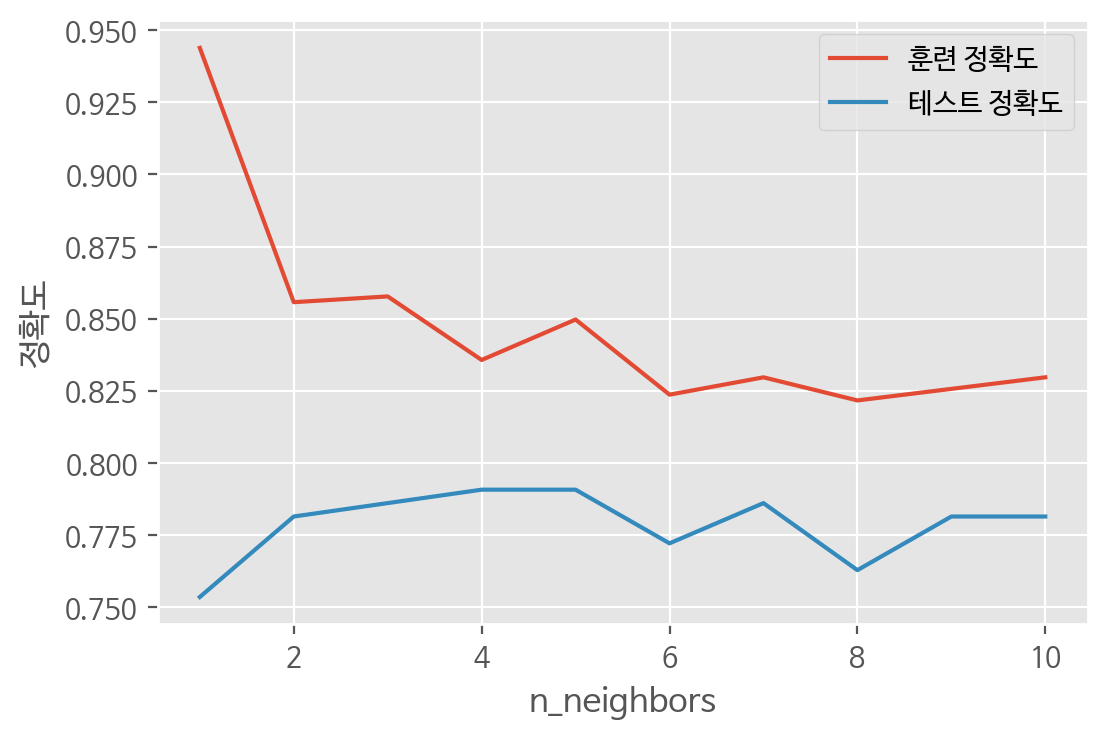

In [36]:

train_accuracy = []
test_accuracy = []

# 1에서 10까지 n_neighbors를 적용한다.

neighbor_setting = range(1, 11) # 범위값을 줌

for n_neighbors in neighbor_setting:
  # 모델 생성하기
  clf = KNeighborsClassifier(n_neighbors=n_neighbors)
  clf.fit(X_train, y_train)

  # 훈련세트 정확도 저장하기
  train_accuracy.append(clf.score(X_train, y_train))

  # 테스트 세트 정확도 저장하기
  test_accuracy.append(clf.score(X_test, y_test))


plt.figure(dpi = 100)
plt.style.use('ggplot')
plt.rc('font', family = 'NanumBarunGothic')

plt.plot(neighbor_setting, train_accuracy, label='훈련 정확도')
plt.plot(neighbor_setting, test_accuracy, label='테스트 정확도')
plt.ylabel('정확도')
plt.xlabel('n_neighbors')

plt.legend()
plt.show()
